In [296]:
import numpy as np
from lmfit import minimize, Parameters

In [297]:
def trans_matrix(a , b , c, x,y,z):
    # T (ki to t), rotate and transport matrix
    Rz = np.matrix([[1,0,0],
          [0, np.cos(a), -np.sin(a)],
         [0, np.sin(a), np.cos(a)]])
    Ry = np.matrix([[np.cos(b), 0 , np.sin(b)],
          [0 , 1, 0],
          [-np.sin(b), 0 , np.cos(b)]])
    Rx = np.matrix([[np.cos(c), -np.sin(c), 0],
         [np.sin(c), np.cos(c), 0],
         [0,0,1]])
    R = np.dot(Rz,np.dot(Ry,Rx))
    T = np.concatenate((R, np.matrix([[x],[y],[z]])), axis=1)
    
    return T

In [298]:
T = trans_matrix(1,1,1,1,1,1)
T

matrix([[ 0.29192658, -0.45464871,  0.84147098,  1.        ],
        [ 0.83722241, -0.30389665, -0.45464871,  1.        ],
        [ 0.46242567,  0.83722241,  0.29192658,  1.        ]])

In [299]:
def depth_map(u, D):
    # inception depth map
    # input u : 2*1
    # output D: 1*1
    u = np.around(u,decimals=0)
    
    l = len(u)
    temp = np.zeros(l)
    for i in range(l):
        temp[i] = D[int(u[i,0])][int(u[i,1])]
    
    return temp

In [300]:
def intensity_img(u,I):
    #intensity image
    u = np.around(u, decimals=0)

    l = len(u)
    temp = np.zeros(l)
    for i in range(l):
        temp[i] = I[int(u[i,0])][int(u[i,1])]
    
    return temp

In [301]:
def model_3d(u, K,D):
    # input u : 2*1, K : 3*3
    # output [V,1] : 4*1
    l = len(u)
    for i in range(l):
        U = np.matrix([[u[i,0]],[u[i,1]],[1]])
        V = np.dot(np.linalg.inv(K),U)
        V = V*depth_map([u[i]],D)
        V = np.concatenate((V, [[1]]), axis=0)
        if i == 0:
            temp = V
        else:
            temp =  np.concatenate((temp,V), axis=1)
    return temp


In [302]:
def pi_trans(x,l):
    u = np.zeros((l,2))
    for i in range(l):
        u[i,0] = x[0,i]/x[2,i]
        u[i,1] = x[1,i]/x[2,i]
    return u

In [303]:
def residual(params, x, data, It, D, K):
    alpha = params['alpha']
    beta = params['beta']
    gamma = params['gamma']
    dx = params['dx']
    dy = params['dy']
    dz = params['dz']

    T = trans_matrix(alpha, beta, gamma, dx,dy,dz)
    l = len(x)
    temp = np.dot(K, np.dot(T,model_3d(x,K,D)))
    temp = pi_trans(temp,l)
    model = intensity_img(temp,It)
    return (data-model)/eps_data

In [304]:
params = Parameters()
params.add('alpha', value=0.0)
params.add('beta', value=0.0)
params.add('gamma', value=0.0)
params.add('dx', value=0.0)
params.add('dy', value=0.0)
params.add('dz', value=0.0)
I_ki = np.random.rand(4,4)
It = np.random.rand(4,4)
D = np.random.rand(4,4)
K = np.random.rand(3,3)

x = np.array([[0,0],[0,1],[0,2],[1,1],[1,2],[2,2],[2,1]])
data = intensity_img(x, I_ki)
#data = np.array([1,1,1,1,1,1,1])

out = minimize(residual, params, args=(x, data, It, D, K))

In [305]:
out.params.pretty_print()

Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
alpha         0     -inf      inf        0     True     None     None
beta          0     -inf      inf        0     True     None     None
dx            0     -inf      inf        0     True     None     None
dy            0     -inf      inf        0     True     None     None
dz     1.49e-08     -inf      inf        0     True     None     None
gamma         0     -inf      inf        0     True     None     None


In [306]:
import cv2

In [307]:
import h5py
import matplotlib.pyplot as plt
#load data from NYU Depth V2
#Dataset = scipy.io.loadmat('nyu_depth_v2_labeled')
#splits = scipy.io.loadmat('splits')
f = h5py.File('nyu_depth_v2_labeled.mat', 'r')
#f = h5py.File('splits.mat', 'r')
#print(f.items())
for k, v in f.items():
    print(k,'      ',v)

#refs#        <HDF5 group "/#refs#" (8484 members)>
#subsystem#        <HDF5 group "/#subsystem#" (1 members)>
accelData        <HDF5 dataset "accelData": shape (4, 1449), type "<f4">
depths        <HDF5 dataset "depths": shape (1449, 640, 480), type "<f4">
images        <HDF5 dataset "images": shape (1449, 3, 640, 480), type "|u1">
instances        <HDF5 dataset "instances": shape (1449, 640, 480), type "|u1">
labels        <HDF5 dataset "labels": shape (1449, 640, 480), type "<u2">
names        <HDF5 dataset "names": shape (1, 894), type "|O">
namesToIds        <HDF5 dataset "namesToIds": shape (1, 6), type "<u4">
rawDepthFilenames        <HDF5 dataset "rawDepthFilenames": shape (1, 1449), type "|O">
rawDepths        <HDF5 dataset "rawDepths": shape (1449, 640, 480), type "<f4">
rawRgbFilenames        <HDF5 dataset "rawRgbFilenames": shape (1, 1449), type "|O">
sceneTypes        <HDF5 dataset "sceneTypes": shape (1, 1449), type "|O">
scenes        <HDF5 dataset "scenes": shape (1, 14

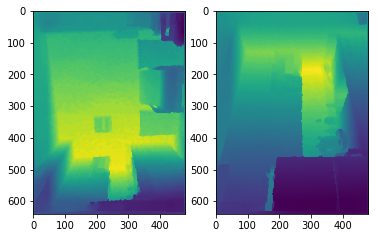

In [308]:
dset_image0 = f['images']
dset_depth0 = f['depths']
plt.figure(1)
plt.subplot(121)
plt.imshow(dset_depth0[0])

plt.subplot(122)
plt.imshow(dset_depth0[1])
plt.show()

In [309]:
dset_depth0[1].shape

(640, 480)

In [310]:
x = []
for i in range(400, 500):
    for j in range(150, 250):
        x.append([i,j])
x = np.array(x)

In [315]:
params = Parameters()
params.add('alpha', value=1.0)
params.add('beta', value=1.0)
params.add('gamma', value=1.0)
params.add('dx', value=0.0)
params.add('dy', value=0.0)
params.add('dz', value=0.0)
I_ki = dset_image0[0][0]
It = dset_image0[1][0]
D = dset_depth0[0]
K = [
    [10,0,1],
    [0,10,1],
    [0,0,1]
]

data = intensity_img(x, I_ki)
#data = np.array([1,1,1,1,1,1,1])

out = minimize(residual, params, args=(x, data, It, D, K ))

In [316]:
out.params.pretty_print()

Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
alpha         1     -inf      inf        0     True     None     None
beta          1     -inf      inf        0     True     None     None
dx            0     -inf      inf        0     True     None     None
dy            0     -inf      inf        0     True     None     None
dz     1.49e-08     -inf      inf        0     True     None     None
gamma         1     -inf      inf        0     True     None     None
